In [ ]:
# default_exp funcs.merfish_eval

In [ ]:
%load_ext autoreload
%autoreload 2

# MERFISH routines

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.plotting import *
import shutil

from numba import njit
from scipy.spatial import cKDTree
from decode_fish.funcs.matching import matching

import io, requests
from sklearn.neighbors import NearestNeighbors
# from starfish import data
# import torch.tensor as T

import pprint

In [ ]:
#export
def plot_gene_numbers(bench_counts, res_counts, title='', log=True, corr=True, algo1='Baseline', algo2='DECODE'):
    
    if corr:
        r = np.corrcoef(bench_counts, res_counts)[0, 1]   
        r = np.round(r, decimals=3)
    else:
        r = [int(np.sum(bench_counts)), int(np.sum(res_counts))]
    x_lim = np.max([bench_counts.max(), res_counts.max()])
    x = np.linspace(0, x_lim)
    
    plt.scatter(bench_counts, res_counts, 50, zorder=2)
    plt.plot(x, x, '-k', zorder=1)

    plt.xlabel(f'Gene copy number {algo1}')
    plt.ylabel(f'Gene copy number {algo2}')
    if log:
        plt.xscale('log')
        plt.yscale('log')
    plt.title(f'{title} r = {r}');

In [ ]:
#export
def plot_gene_panels(res_df, bench_df, targets, matches=None, algo1='Baseline', algo2='DECODE'):
    
    bench_counts = DF(data=None, index=targets)
    bench_counts['Res_all'] = res_df.groupby('gene')['gene'].count()
    bench_counts['Bench_all'] = bench_df.groupby('gene')['gene'].count()
    bench_counts = bench_counts.fillna(0)

    if matches is not None:
        fps = res_df.loc[~res_df['loc_idx'].isin(matches['loc_idx_pred'])]
        fns = bench_df.loc[~bench_df['loc_idx'].isin(matches['loc_idx_tar'])]

        bench_counts['Res_fp'] = fps.groupby('gene')['gene'].count()
        bench_counts['Res_fns'] = fns.groupby('gene')['gene'].count()
    
    bench_counts=bench_counts.fillna(0)    
    
    print(len(bench_df), len(res_df))

    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plot_gene_numbers(bench_counts['Bench_all'].values, bench_counts['Res_all'].values, 'All', log=False,  algo1=algo1, algo2=algo2)

    binds = []
    for i,g in enumerate(targets):
        if 'Blank' in g:
            binds.append(g)

    plt.subplot(132)
    plot_gene_numbers(bench_counts.loc[binds, 'Bench_all'].values, bench_counts.loc[binds,'Res_all'].values, 'Blanks', log=False, corr=False,  algo1=algo1, algo2=algo2)

    if 'Res_fp' in bench_counts:
        plt.subplot(133)
        plot_gene_numbers(bench_counts['Bench_all'].values, bench_counts['Res_fp'].values, 'False Pos.', log=False,  algo1=algo1, algo2=algo2)

13800 17500


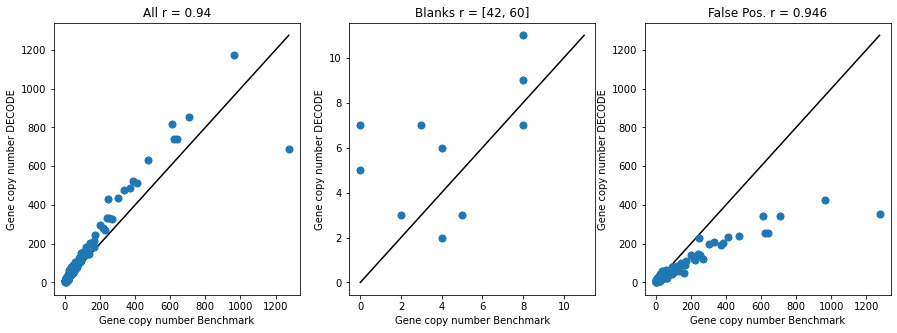

In [ ]:
plot_gene_panels(res_sub, bench_match, matches, targets)

In [ ]:
# export
# def make_roc(df, var='code_err', ascending=True, n_max=30000):
    
#     if n_max is None:
#         n_max = len(df)
#     x = np.arange(0,n_max,100)
#     df = df.sort_values(var, ascending=ascending)
#     n_blanks = []
#     c_blanks = 0
#     for i in range(1, len(x)):
#         c_blanks += (df[x[i-1]:x[i]]['class'] == 1).sum()
#         n_blanks.append((c_blanks).sum())
        
#     return x[1:], n_blanks

def make_roc(df, var='int_ratio', ascending=True):

    return df.sort_values(var, ascending=ascending)['class'].cumsum().values

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 02b_place_psfs.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_matching.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted 25_ensembling.ipynb.
Converted 26_gen_train.ipynb.
Converted 27_testtime_rescale.ipynb.
Converted index.ipynb.
